In [90]:
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### Acceso a los datos

In [91]:
# Accedo y descargo los archivos de precios del dolar en S3
s3_resource = boto3.resource('s3')
s3_client = boto3.client('s3')
bucket_name = 'proccesed-dollar-mia-electiva-3'

bucket = s3_resource.Bucket(bucket_name)

folder_name = 'precios_dolar'

for obj in bucket.objects.all():
    s3_client.download_file(bucket_name, obj.key, f'{folder_name}/{obj.key}')

In [128]:
# Lee todos los archivos para extraer el precio diario del dolar al cierre de la jornada
all_data_dollar_price = []

for filename in os.listdir(folder_name):
    file_path = (os.path.join(folder_name, filename))
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, usecols=['fecha', 'valor'], parse_dates=['fecha'])
        all_data_dollar_price.append(df)

df_dollar_price = pd.concat(all_data_dollar_price).reset_index(drop=True)

In [129]:
# Transformo el dataset para dejar un registro por cada 15min(por día no es posible, al contar con solo 31 días de ejecución del lambda)
df_dollar_price.set_index('fecha', inplace=True)
df_dollar_15min_price = df_dollar_price.resample("15Min").mean()
df_dollar_15min_price.reset_index(inplace=True)

In [130]:
df_dollar_15min_price

,fecha,valor
0,2023-02-17 13:15:00,4942.824392
1,2023-02-17 13:30:00,4936.291246
2,2023-02-17 13:45:00,4931.374835
3,2023-02-17 14:00:00,4931.280810
4,2023-02-17 14:15:00,4932.116995
...,...,...
4527,2023-04-05 17:00:00,4571.232284
4528,2023-04-05 17:15:00,4570.940456
4529,2023-04-05 17:30:00,4570.781019
4530,2023-04-05 17:45:00,4570.749058


In [95]:
# Renombro columnas
df_dollar_15min_price = df_dollar_15min_price.rename(columns={'valor':'precio'})

### Explorar los datos

In [96]:
# Elimino nulos
df_dollar_15min_price = df_dollar_15min_price.dropna()

In [97]:
# Elimino duplicados
df_dollar_15min_price = df_dollar_15min_price.drop_duplicates()

In [98]:
df_dollar_15min_price.dtypes

fecha     datetime64[ns]
precio           float64
dtype: object

In [99]:
# Ordeno por fechas
df_dollar_15min_price = df_dollar_15min_price.sort_values(by='fecha')
df_dollar_15min_price = df_dollar_15min_price.reset_index(drop=True)

In [100]:
df_dollar_15min_price.describe()

,precio
count,624.000000
mean,4768.128487
std,102.599283
min,4565.378875
25%,4688.156014
50%,4776.603126
75%,4848.528354
max,4949.894898


<AxesSubplot: xlabel='fecha'>

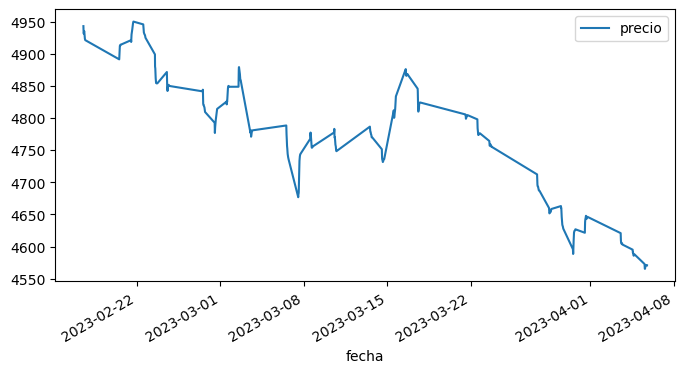

In [101]:
df_dollar_15min_price.plot(x='fecha', y=['precio'], figsize=(8,4))

In [102]:
df_dollar_15min_price

,fecha,precio
0,2023-02-17 13:15:00,4942.824392
1,2023-02-17 13:30:00,4936.291246
2,2023-02-17 13:45:00,4931.374835
3,2023-02-17 14:00:00,4931.280810
4,2023-02-17 14:15:00,4932.116995
...,...,...
619,2023-04-05 17:00:00,4571.232284
620,2023-04-05 17:15:00,4570.940456
621,2023-04-05 17:30:00,4570.781019
622,2023-04-05 17:45:00,4570.749058


In [105]:
# Guardo el dataset procesado
df_dollar_15min_price.to_csv('dollar_15min_price.csv', index=False)

#### Tendencia

<AxesSubplot: >

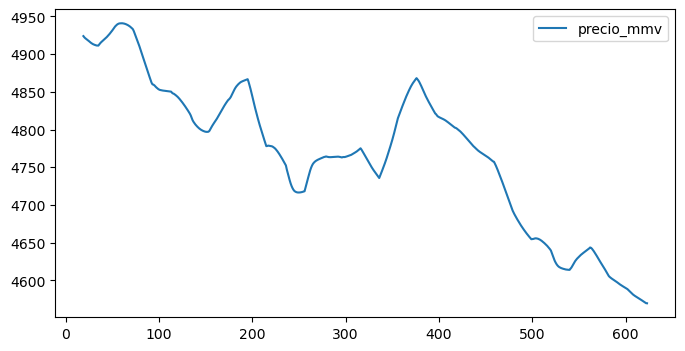

In [106]:
# Media movil
df_mmv = pd.DataFrame({'fecha':df_dollar_15min_price['fecha']})
df_mmv['precio_mmv'] = df_dollar_15min_price['precio'].rolling(window=20).mean()
df_mmv.plot(y=['precio_mmv'], figsize=(8,4))

#### Estacionalidad

In [107]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

##### Metodo Media Movil

In [108]:
df_test_adfuller = sm.tsa.stattools.adfuller(df_dollar_15min_price['precio'], autolag='AIC')
result = pd.Series(df_test_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -0.734485
p-value                          0.837614
#Lags Used                       1.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64


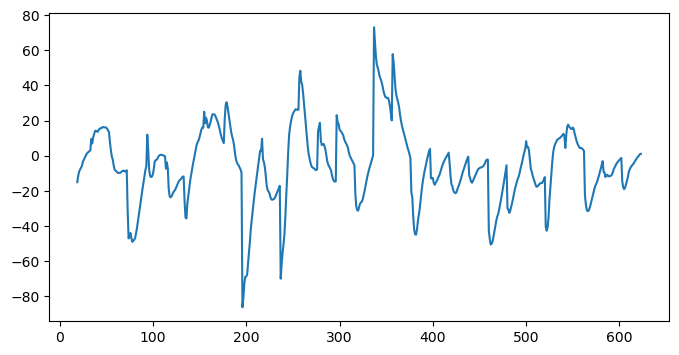

In [109]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de resta de la media movil
mmv_diff = df_dollar_15min_price['precio']-df_mmv['precio_mmv']
plt.figure(figsize=(8,4))
plt.plot(mmv_diff, label='Diferencia entre precio y media movil')
plt.show()
mmv_diff.dropna(inplace=True)

In [110]:
df_mmv_adfuller = sm.tsa.stattools.adfuller(mmv_diff, autolag='AIC')
result = pd.Series(df_mmv_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_mmv_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -4.796459
p-value                          0.000055
#Lags Used                       2.000000
Number of Observations Used    602.000000
Critical Value (1%)             -3.441259
Critical Value (5%)             -2.866353
Critical Value (10%)            -2.569333
dtype: float64


##### Metodo de Mevia Movil con transformacion logaritmica

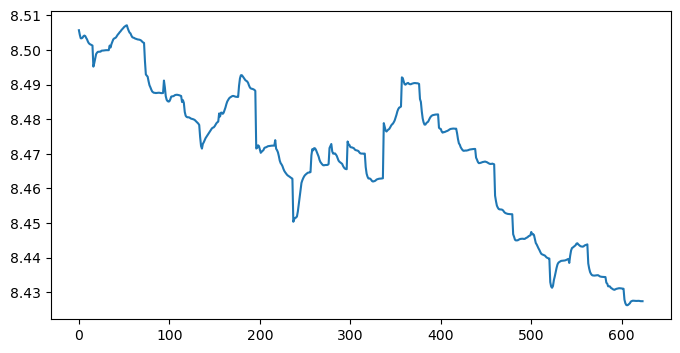

In [111]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de resta de la media movil con transformacion logaritmica
precio_log = np.log(df_dollar_15min_price['precio'])
plt.figure(figsize=(8,4))
precio_log.plot(label='Precio con transformacion logaritmica')
plt.show()

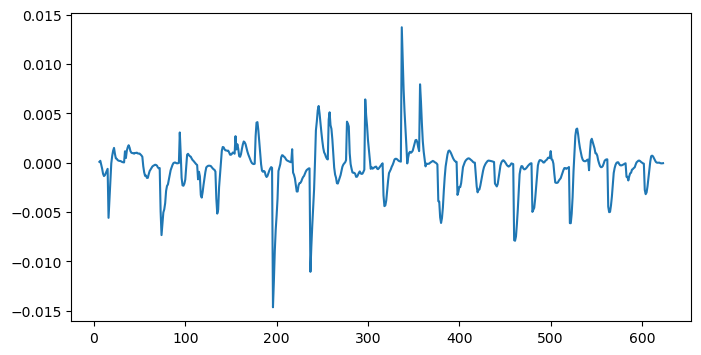

In [112]:
log_mmv = pd.Series.rolling(precio_log,window=7,center=False).mean()
log_mmv_diff = precio_log-log_mmv
plt.figure(figsize=(8,4))
plt.plot(log_mmv_diff, label='Diferencia entre precio y media movil')
plt.show()
log_mmv_diff.dropna(inplace=True)

In [113]:
df_log_adfuller = sm.tsa.stattools.adfuller(log_mmv_diff, autolag='AIC')
result = pd.Series(df_log_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_log_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                -9.002968e+00
p-value                        6.423159e-15
#Lags Used                     3.000000e+00
Number of Observations Used    6.140000e+02
Critical Value (1%)           -3.441045e+00
Critical Value (5%)           -2.866259e+00
Critical Value (10%)          -2.569283e+00
dtype: float64


##### Metodo de diferencia de primer orden

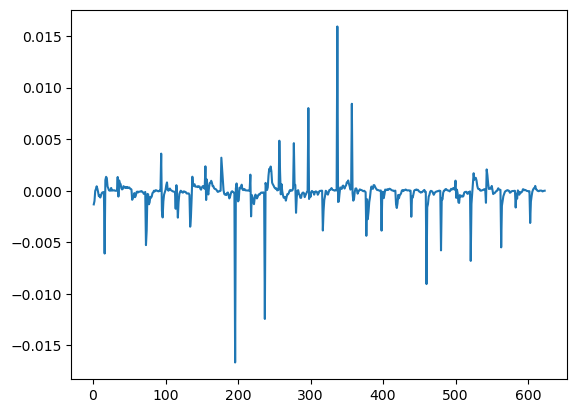

In [114]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de diferencia de primer orden
precio_log_diff = precio_log - precio_log.shift()
precio_log_diff.dropna(inplace=True)
plt.plot(precio_log_diff)
plt.show()

In [115]:
df_log_diff_adfuller = sm.tsa.stattools.adfuller(precio_log_diff, autolag='AIC')
result = pd.Series(df_log_diff_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_log_diff_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                 -22.201559
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64


#### Conclusión
El metodo de transformación por diferencia de primer orden dio el mejor resultado dando un resultado aceptable en el nivel de estacionalidad

### Time Lags

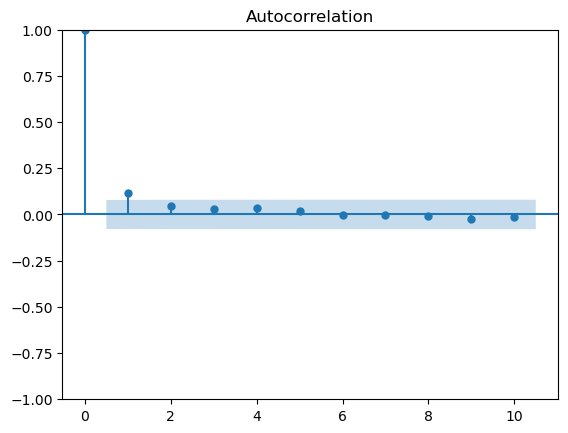

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


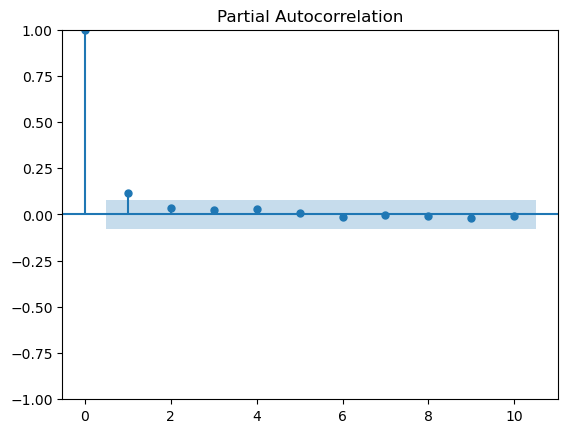

In [116]:
plot_acf(precio_log_diff,lags=10)
plt.show()

plot_pacf(precio_log_diff,lags=10)
plt.show()

#### Conclusión
No hay autocorrelacion entre los datos

### Modelo de Predicción - Tests

In [117]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [118]:
df_for_prediction = df_dollar_15min_price.copy()
df_for_prediction.set_index('fecha', inplace=True)

#### ARIMA

In [119]:
train_size = math.ceil(len(df_for_prediction) * 0.8)
train_data = df_for_prediction.values[:train_size]
test_data = df_for_prediction.values[train_size:]

In [120]:
X = df_for_prediction.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/tsa/statespace/tools.py:538: RuntimeWarning: invalid value encountered in true_divide
  x = r / ((1 - r**2)**0.5)


Test MSE: 52.333


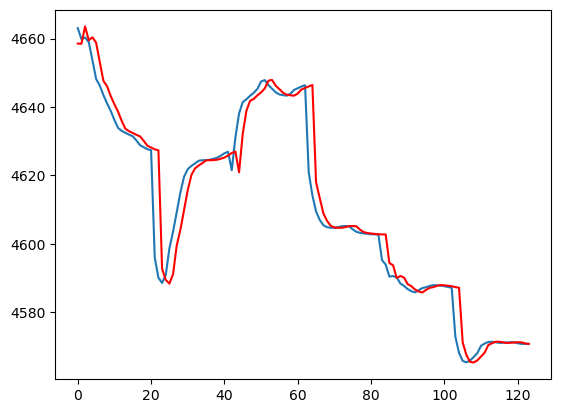

In [121]:
history = [x for x in train_data]
predictions = list()
# walk-forward validation
for t in range(len(test_data)):
 model = ARIMA(history, order=(1,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
mse = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

#### Regresor con Arboles de Decisión

In [122]:
df_for_rf_regressor =  df_dollar_15min_price.copy()
df_for_rf_regressor.drop(columns=['fecha'], axis=1, inplace=True)
df_for_rf_regressor['precio_ayer'] = df_for_rf_regressor['precio'].shift(1)
df_for_rf_regressor.dropna(inplace=True)

In [123]:
train_size = math.ceil(len(df_for_rf_regressor) * 0.7)
train_data = df_for_rf_regressor[:train_size]
test_data = df_for_rf_regressor[train_size:]

In [124]:
train_data.dtypes

precio         float64
precio_ayer    float64
dtype: object

In [125]:
regressor = DecisionTreeRegressor(max_depth=3)

regressor.fit(train_data.drop('precio', axis=1), train_data['precio'])

DecisionTreeRegressor(max_depth=3)

In [126]:
predictions = regressor.predict(test_data.drop('precio', axis=1))
predictions

array([4769.36446456, 4769.36446456, 4769.36446456, 4769.36446456,
       4769.36446456, 4769.36446456, 4769.36446456, 4769.36446456,
       4769.36446456, 4769.36446456, 4769.36446456, 4769.36446456,
       4769.36446456, 4769.36446456, 4769.36446456, 4769.36446456,
       4769.36446456, 4769.36446456, 4769.36446456, 4769.36446456,
       4769.36446456, 4769.36446456, 4769.36446456, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656983,
       4729.92656983, 4729.92656983, 4729.92656983, 4729.92656